In [1]:
from segmentation import *
from mobilenetv2 import *

/model-data


In [2]:
import collections
import hashlib
import os.path
import random
import re
import sys

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model
from keras.layers import Dense, Input, LSTM
from pathlib import Path
import sklearn
from sklearn import datasets,metrics
import shutil
from keras import initializers
from keras.models import load_model
import pickle
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from IPython.display import Image,display,clear_output
import cv2
import matplotlib.pyplot as plt
import time 

Instructions for updating:
Please file an issue at https://github.com/tensorflow/tensorflow/issues if you depend on this feature.


W0710 12:10:05.876649 139971991963392 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [3]:
def get_pretrained_base_model_for_bottlenecks(show_model_summary = False):
    #Arguments     : show_model_summary--> whether to show model summary/layers
    #Returns       : models-->mobilenetV2 with its last layer being 'global_average_pooling2d_1'
    
    model = MobileNetV2()
    if show_model_summary:
        model.summary()
    base_model = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d_1').output)
    print("Base_model_loaded 100 percent")
    return base_model

In [4]:
#Loading trained models

marker_model=load_model("model/initial_human_seg_marker_model.h5")
action_model=load_model("eighth_try/human_seg_rnn_mask_model.h5")
mobilenet_model=get_pretrained_base_model_for_bottlenecks(False)
class_names = ['ABOVE', 'ACCIDENT', 'ADVISE_or_INFLUENCE', 'AFTERNOON', 'AGAIN', 'ALLIGATOR', 'ANSWER' ,'A_LOT', 'BECAME', 'COME_HERE', 'EXCEED', 'GENERATION', 'LESS_THAN', 'OF' ,'THREAT', 'TOTAL']

Instructions for updating:
Colocations handled automatically by placer.


W0710 12:10:31.958799 139971991963392 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0710 12:10:31.986343 139971991963392 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


W0710 12:10:34.116387 139971991963392 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Marker Model Loaded
Base_model_loaded 100 percent
Action Model Loaded


In [6]:

def video_to_frames(video_path):
    #Arguments     : video_path-->path to the video location in storage
    #Returns       : names-->list of path to all the frames of video
    #                frame_cache-->numpy array containing frames 
    #Description   : Extracts frames from video
    
    vidObj = cv2.VideoCapture(video_path)
    count = 0
    success = 1
    ensure_folder_exists(frame_target_dir)
    names=[]
    frame_cache=[]
    while success: 
        success, image = vidObj.read() 
        if image is None:
            continue
        framename=frame_target_dir+str(count)+".jpeg"
        #image=image[120:,320:-320,:]
        #image=cv2.resize(image, dsize=(640,480), interpolation=cv2.INTER_CUBIC)
        #im = Image.fromarray(image)
        #im.save(framename)
        #img = load_img(framename)
        #image = img_to_array(img)
        #image=cv2.imread(framename)
        frame_cache.append(image)
        cv2.imwrite(framename,image)
        names.append(framename)
        count += 1
        
    print("Video to frame done")
    return names,np.asarray(frame_cache)

In [7]:
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [8]:
def frames_to_segmented_frames(names):
    #Arguments     : names-->list of path to all the frames of video
    #Returns       : frames-->numpy array containing segmented frames 
    #Description   : Do the human segmentation to each frame
    
    frames = []
    ensure_folder_exists(seg_frame_target_dir)
    count = 0
    framenames = []
    for name in names:
        #img=load_img(name)
        #img=img_to_array(img)
        #frames.append(img)
        framename=seg_frame_target_dir+str(count)+".jpeg"
        framenames.append(framename)
        count = count+1
        if os.path.exists(framename):
            continue
        img = cv2.imread(name)
        img = human_segmentation(np.reshape(img,(1,img.shape[0],img.shape[1],img.shape[2])))
        img = np.asarray(img)
        img = np.reshape(img, (img.shape[1],img.shape[2],img.shape[3]))
        cv2.imwrite(framename, img)
        
    for framename in framenames:
        img = load_img(framename)
        img = img_to_array(img)
        frames.append(img)
    
    print("Segmentation done")
    return frames

In [9]:
def is_marker_frame(frame):
    #Arguments     : frame-->frame array with shape (width,height,depth)
    #Returns       : Boolean-->Is given frame is marker frame
    #Description   : checks for marker using marker model
    
    if(len(frame.shape)==3):
        frame=np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2]))
    prediction=marker_model.predict(frame)
    return prediction.argmax(axis=-1)

In [10]:
def action_prediction(action_frames,end_buffer,j):
    #Arguments     : action_frames-->list of frames on which gesture has to be predicted
    #Returns       : Predicted class name
    #Description   : uses mobilenetV2  model and rnn trained model to predict action
    
    action_frames=np.asarray(action_frames)
    action_frames=action_frames[:-end_buffer,:,:,:]
    action_frames = preprocess_input(action_frames)
    new_frames=[]
    # resize command
    for i in range(action_frames.shape[0]):
        new_frames.append(cv2.resize(action_frames[i,:,:,:], dsize=(224, 224), interpolation=cv2.INTER_CUBIC))
    action_frames=np.asarray(new_frames)    
    features=mobilenet_model.predict(action_frames)
    features=np.reshape(features,(1,features.shape[0],features.shape[1]))
    prediction=action_model.predict(features)
    #print(prediction)
    class_predicted=class_names[prediction.argmax()]
    #print("Action "+ str(j) + "- " + class_predicted)
    return "Action "+str(j)+"- "+class_predicted

In [11]:
def marker_analysis(marker_counter,nonmarker_counter,continouos_marker,continouos_nonmarker,current_status):
    #Description   : This function checks what is status currently while propagating through frames and 
    #                whether marker has ended/started/going-on.
    
    if(continouos_marker>=5):
        if(current_status!="marker"):
            return "marker_starts"
    if(continouos_nonmarker>=5):
        if(current_status!="append_frames"):
            return "action_starts"
    else:
        return "nothing"

In [12]:
# Initialising directory paths
video_path="pipeline/xyz_our.mp4"
frame_target_dir="pipeline/xyz_ours/"
seg_frame_target_dir = "pipeline/xyz_seg_ours/"

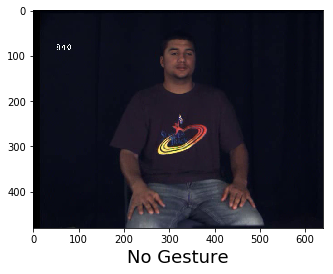

Start frames =  [12, 212]
End frames =  [73, 268]
Number of action= 2
Action 1- AFTERNOON
Action 2- AGAIN


In [23]:
#Main pipeline execution

number_of_action=0
marker_counter=0
nonmarker_counter=0
continouos_marker=0
continouos_nonmarker=0
i=0
start_frame=[]
end_frame=[]
action_frame_cache=[]
action_cache=[]
end_buffer=5
current_status="marker"
next_step="nothing"


#First we extract frames from video and then do human segmentation on them
names,frame_cache=video_to_frames(video_path)
frames=frames_to_segmented_frames(names)
frames=np.asarray(frames)
marker_cache=[]
print("marker_starts")


#We propagate through all frames check is current frame is marker or not.
#We also keep track of how many of the last few frames are marker/non-marker
#And on the basis of that we decide whether marker has started/ended.
#Whenever marker ends, we start stacking till marker starts so that 
#stacked up frames(representing some action) can be feeded to model
#to get prediction accordingly

for frame in frames:
    if(is_marker_frame(frame/255)):
        #print(i,"Marker")
        marker_cache.append("No Gesture Happening")
        marker_counter+=1
        continouos_marker+=1
        continouos_nonmarker=0   
        if i%3==0:
            clear_output(wait=True)
            plt.imshow(cv2.cvtColor(frame_cache[i,:,:,:], cv2.COLOR_BGR2RGB))
            plt.xlabel("No Gesture",fontsize=18)
            plt.pause(0.001)
    else:
        #print(i,"Non-Marker")
        marker_cache.append("Gesture Happening")
        nonmarker_counter+=1
        continouos_marker=0
        continouos_nonmarker+=1
        if i%6==0:
            clear_output(wait=True)
            plt.imshow(cv2.cvtColor(frame_cache[i,:,:,:], cv2.COLOR_BGR2RGB))
            plt.xlabel("Gesture",fontsize=18)
            plt.pause(0.001)
        
    next_step=marker_analysis(marker_counter,nonmarker_counter,continouos_marker,continouos_nonmarker,current_status)
    if(next_step=="action_starts"):
         #print(next_step)
        current_status="append_frames"
        number_of_action+=1
        start_frame.append(i)
        next_step="nothing"
    if(next_step=="marker_starts"):
        #print(number_of_action)
        action_cache.append(action_prediction(action_frame_cache,end_buffer,number_of_action))
         #print(next_step)
        action_frame_cache=[]
        current_status="marker"
        end_frame.append(i)
        next_step="nothing"
    i+=1 
    if(current_status=="append_frames"):
        action_frame_cache.append(frame)
        
#print("marker=",marker_counter)
#print("non-marker=",nonmarker_counter)
print("Start frames = ",start_frame)
print("End frames = ",end_frame)
print("Number of action=",number_of_action)
for i in range(len(action_cache)):
    print(action_cache[i])